In [8]:
import os
import math
import dill
from itertools import permutations

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import HuberRegressor as hubreg
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pingouin import mixed_anova, anova, pairwise_tukey
from statsmodels.regression.mixed_linear_model import MixedLM


import suite2p as s2p

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# for mice in (stx.ymaze_sess_deets.KO_sessions.keys()): #, stx.ymaze_sess_deets.CTRL_sessions.keys()):
# print(mice)
def plot_crossval_placecells(mice, max_sess = 6, key = 'F_dff'):
    fam_dict, nov_dict = {d: {d: [] for d in range(max_sess)} for d in range(max_sess)}, {d: {d: [] for d in range(max_sess)} for d in range(max_sess)}
    fam_sort_dict, nov_sort_dict = {d: [] for d in range(max_sess)}, {d: [] for d in range(max_sess)}
    fam_mu_dict, nov_mu_dict = {d: [] for d in range(max_sess)}, {d: [] for d in range(max_sess)}
    fam_std_dict, nov_std_dict = {d: [] for d in range(max_sess)}, {d: [] for d in range(max_sess)}
    for mouse in mice:
        concat_sess = u.single_mouse_concat_sessions(mouse,date_inds=np.arange(0,max_sess))
        for sort_day in range(max_sess):
            place_cell_mask = concat_sess.place_cell_info[-1*concat_sess.novel_arm]['masks'][sort_day,:] + concat_sess.place_cell_info[concat_sess.novel_arm]['masks'][sort_day,:]>0
            
            trial_mask = (concat_sess.trial_info['sess_num']==sort_day)*(concat_sess.trial_info['LR']==-1*concat_sess.novel_arm)
            trial_inds = np.arange(trial_mask.shape[0])
            trial_inds = trial_inds[trial_mask]
            fr = np.nanmean(concat_sess.trial_matrices[key][trial_inds[::2],:,:],axis=0)[:,place_cell_mask]
            fam_mu, fam_std = fr.mean(axis=0,keepdims=True), fr.std(axis=0,keepdims=True)
            fam_mu_dict[sort_day].append(fam_mu)
            fam_std_dict[sort_day].append(fam_std)
            
            trial_mask = (concat_sess.trial_info['sess_num']==sort_day)*(concat_sess.trial_info['LR']==concat_sess.novel_arm)
            trial_inds = np.arange(trial_mask.shape[0])
            trial_inds = trial_inds[trial_mask]
            fr = np.nanmean(concat_sess.trial_matrices[key][trial_inds[::2],:,:],axis=0)[:,place_cell_mask]
            nov_mu, nov_std = fr.mean(axis=0,keepdims=True), fr.std(axis=0,keepdims=True)
            nov_mu_dict[sort_day].append(nov_mu)
            nov_std_dict[sort_day].append(nov_std)
            
            for day in range(max_sess):
                trial_mask = (concat_sess.trial_info['sess_num']==day)*(concat_sess.trial_info['LR']==-1*concat_sess.novel_arm)
                trial_inds = np.arange(trial_mask.shape[0])
                trial_inds = trial_inds[trial_mask]
                if sort_day==day:
                    fam_sort_dict[sort_day].append(sp.stats.zscore(np.nanmean(concat_sess.trial_matrices[key][trial_inds[::2],:,:],axis=0)[:,place_cell_mask],axis=1))
                    trial_inds = trial_inds[1::2]
#                 fr = sp.stats.zscore(np.nanmean(concat_sess.trial_matrices['F_dff'][trial_inds,:,:],axis=0)[:,place_cell_mask],axis=1)
                fr = np.nanmean(concat_sess.trial_matrices[key][trial_inds,:,:],axis=0)[:,place_cell_mask]
                fam_dict[sort_day][day].append(fr)
                
                trial_mask = (concat_sess.trial_info['sess_num']==day)*(concat_sess.trial_info['LR']==concat_sess.novel_arm)
                trial_inds = np.arange(trial_mask.shape[0])
                trial_inds = trial_inds[trial_mask]
                if sort_day==day:
                    nov_sort_dict[sort_day].append(sp.stats.zscore(np.nanmean(concat_sess.trial_matrices[key][trial_inds[::2],:,:],axis=0)[:,place_cell_mask],axis=1))
                    trial_inds = trial_inds[1::2]
                fr = np.nanmean(concat_sess.trial_matrices[key][trial_inds,:,:],axis=0)[:,place_cell_mask]
                nov_dict[sort_day][day].append(fr)

    for sort_day in range(max_sess):
        fam_sort_dict[sort_day] = np.concatenate(fam_sort_dict[sort_day],axis = -1)
        nov_sort_dict[sort_day] = np.concatenate(nov_sort_dict[sort_day],axis = -1)
        
        fam_mu_dict[sort_day] = np.concatenate(fam_mu_dict[sort_day],axis = -1)
        nov_mu_dict[sort_day] = np.concatenate(nov_mu_dict[sort_day],axis = -1)
        
        fam_std_dict[sort_day] = np.concatenate(fam_std_dict[sort_day],axis = -1)
        nov_std_dict[sort_day] = np.concatenate(nov_std_dict[sort_day],axis = -1)
        
        for day in range(max_sess):
            fam_dict[sort_day][day] = np.concatenate(fam_dict[sort_day][day],axis = -1)
            nov_dict[sort_day][day] = np.concatenate(nov_dict[sort_day][day],axis = -1)

    fig_fam_fam, ax_fam_fam  = plt.subplots(max_sess,max_sess, figsize= [30,30])
    fig_fam_fam.suptitle('Familiar act, Familiar sort')
    
    fig_fam_nov, ax_fam_nov  = plt.subplots(max_sess,max_sess, figsize= [30,30])
    fig_fam_nov.suptitle('Familiar act, Novel sort')
    
    fig_nov_fam, ax_nov_fam  = plt.subplots(max_sess,max_sess, figsize= [30,30])
    fig_nov_fam.suptitle('Novel act, Familiar sort')
    
    fig_nov_nov, ax_nov_nov  = plt.subplots(max_sess,max_sess, figsize= [30,30])
    fig_nov_nov.suptitle('Novel act, Novel sort')
    for sort_day in range(max_sess):
        sort_fam  = np.argsort(np.argmax(fam_sort_dict[sort_day],axis=0))
        sort_nov  = np.argsort(np.argmax(nov_sort_dict[sort_day],axis=0))
        for day in range(max_sess):
            fam_fam = sp.stats.zscore(fam_dict[sort_day][day], axis=0) #(fam_dict[sort_day][day]-fam_mu_dict[sort_day])/fam_std_dict[sort_day]
            fam_nov = sp.stats.zscore(fam_dict[sort_day][day], axis=0) #(fam_dict[sort_day][day] - nov_mu_dict[sort_day])/nov_std_dict[sort_day]
            nov_fam = sp.stats.zscore(nov_dict[sort_day][day], axis=0) #(nov_dict[sort_day][day] - fam_mu_dict[sort_day])/fam_std_dict[sort_day]
            nov_nov = sp.stats.zscore(nov_dict[sort_day][day], axis=0) #(nov_dict[sort_day][day] - nov_mu_dict[sort_day])/nov_std_dict[sort_day]
            

            h = ax_fam_fam[sort_day, day].imshow(fam_fam[:,sort_fam].T, aspect = 'auto', vmax = 4, vmin  =0., cmap = 'pink')
            plt.colorbar(h,ax=ax_fam_fam[sort_day,day])
            
            ax_fam_nov[sort_day, day].imshow(fam_nov[:,sort_nov].T, aspect = 'auto', vmax = 4, vmin  =0., cmap = 'pink')
            
            ax_nov_fam[sort_day, day].imshow(nov_fam[:,sort_fam].T, aspect = 'auto', vmax = 4, vmin  =0., cmap = 'pink')
            
            ax_nov_nov[sort_day, day].imshow(nov_nov[:,sort_nov].T, aspect = 'auto', vmax = 4, vmin  =0., cmap = 'pink')
            
            
    return (fig_fam_fam, ax_fam_fam), (fig_fam_nov, ax_fam_nov), (fig_nov_fam, ax_nov_fam), (fig_nov_nov, ax_nov_nov)

In [21]:
figdir = "/mnt/BigDisk/YMazeResults/neural"

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


28_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


29_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


30_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


01_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


02_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


28_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


29_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


30_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


01_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


02_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']


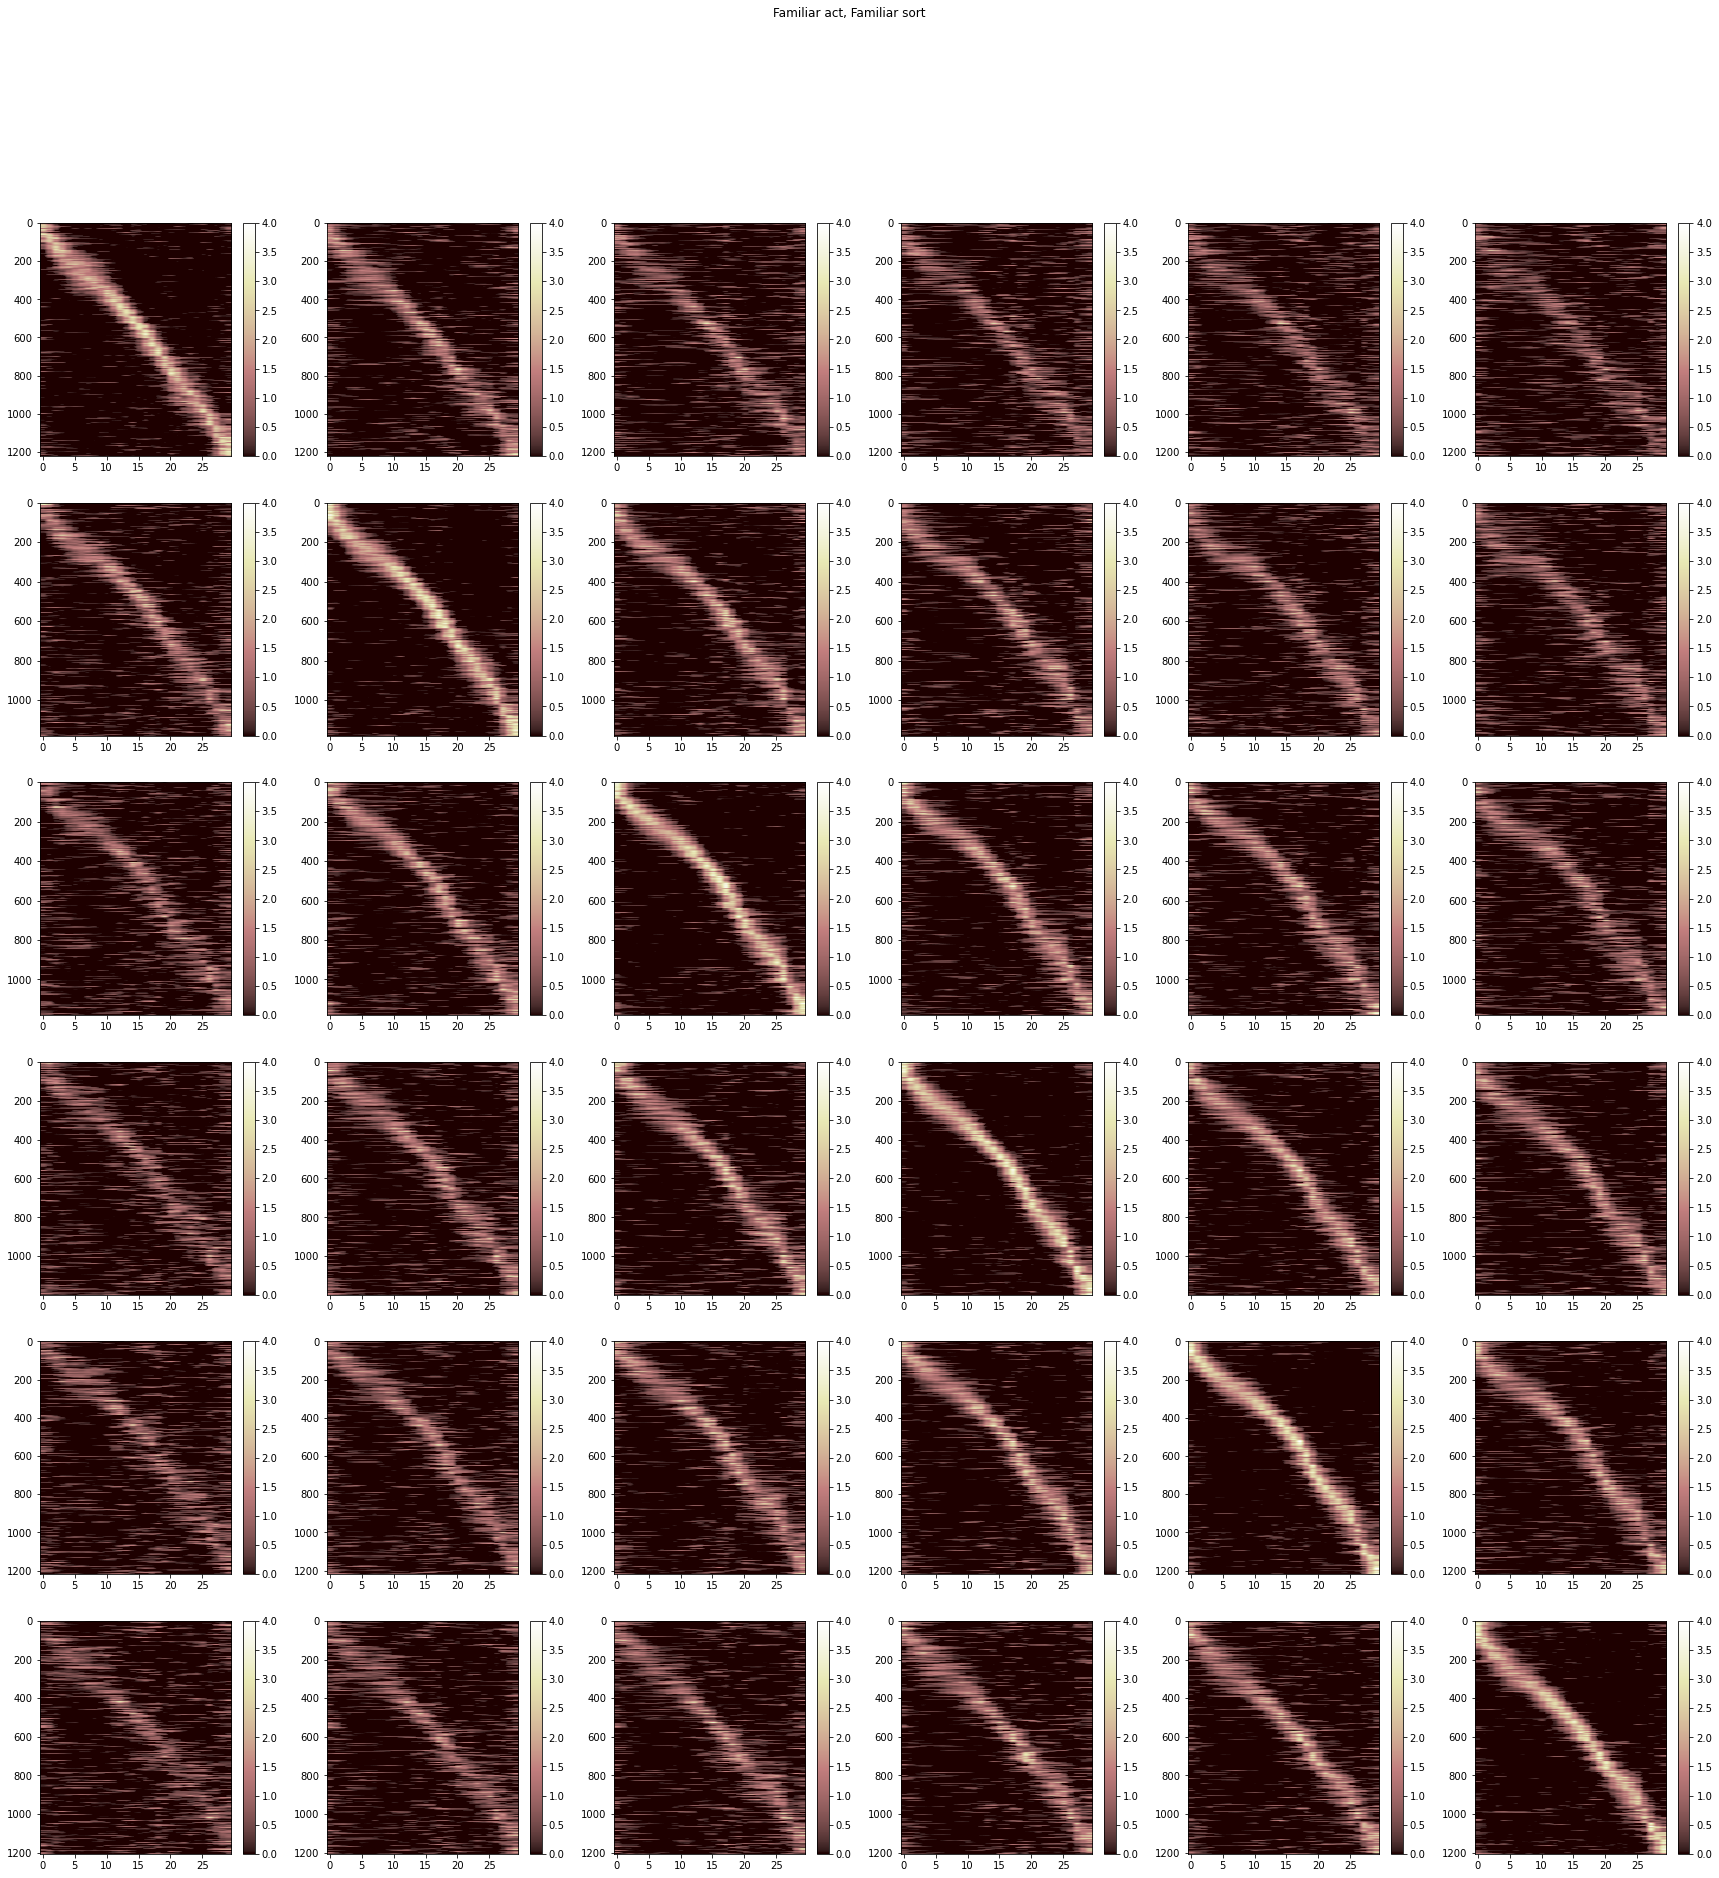

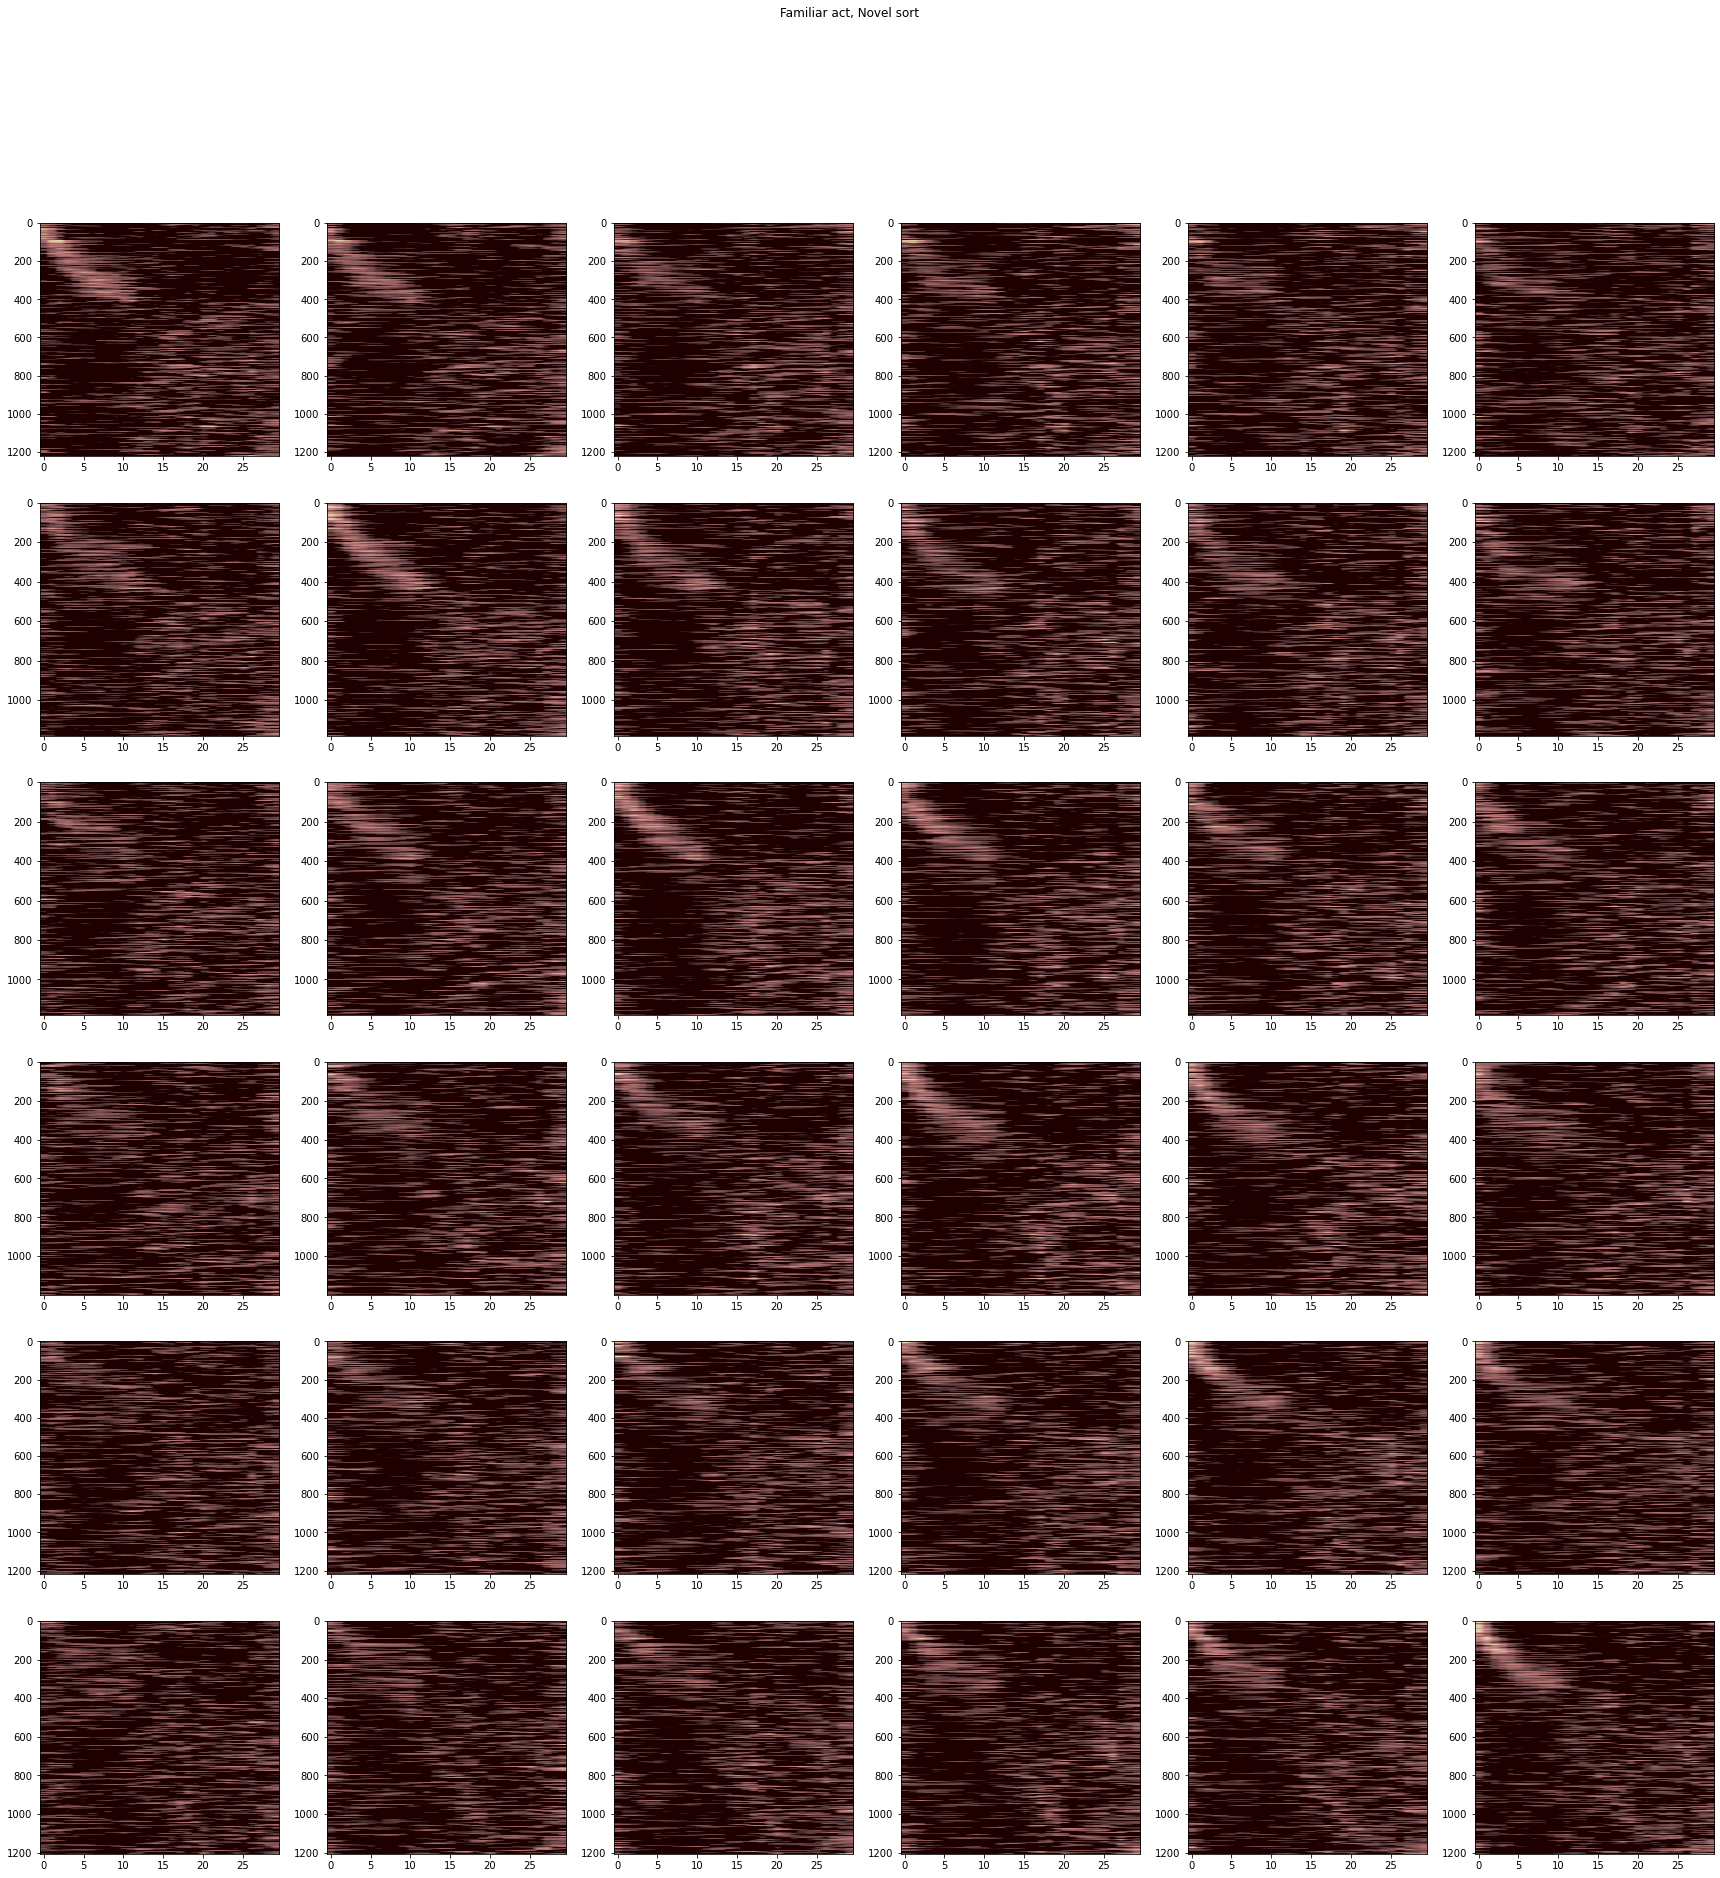

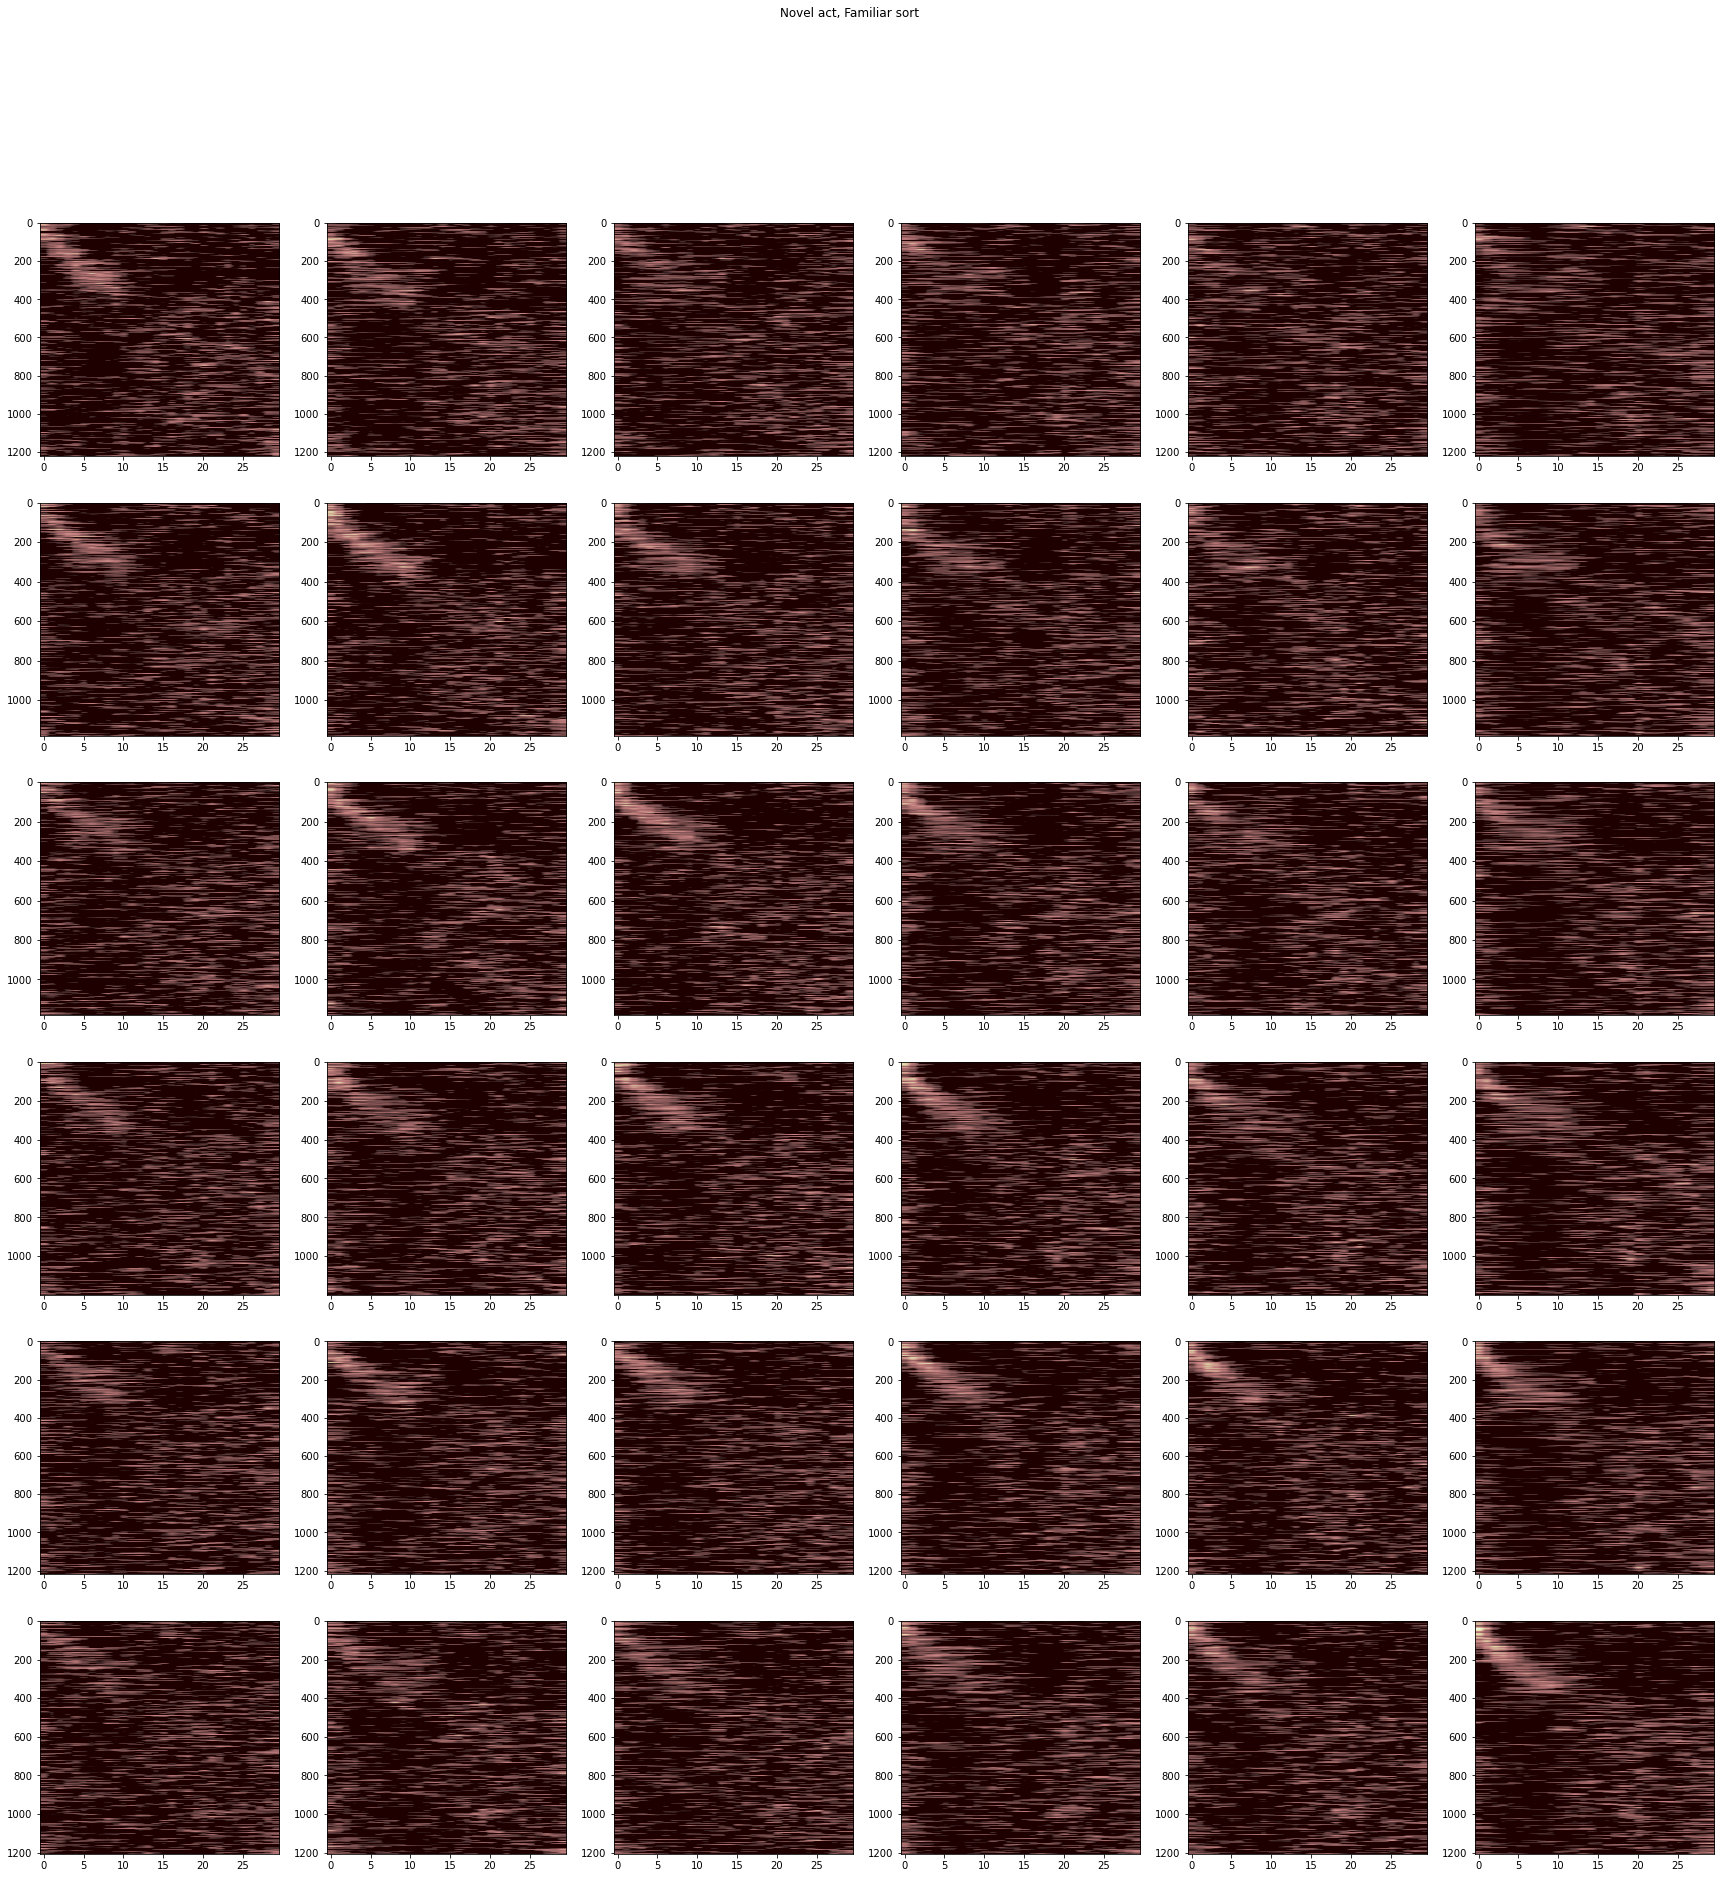

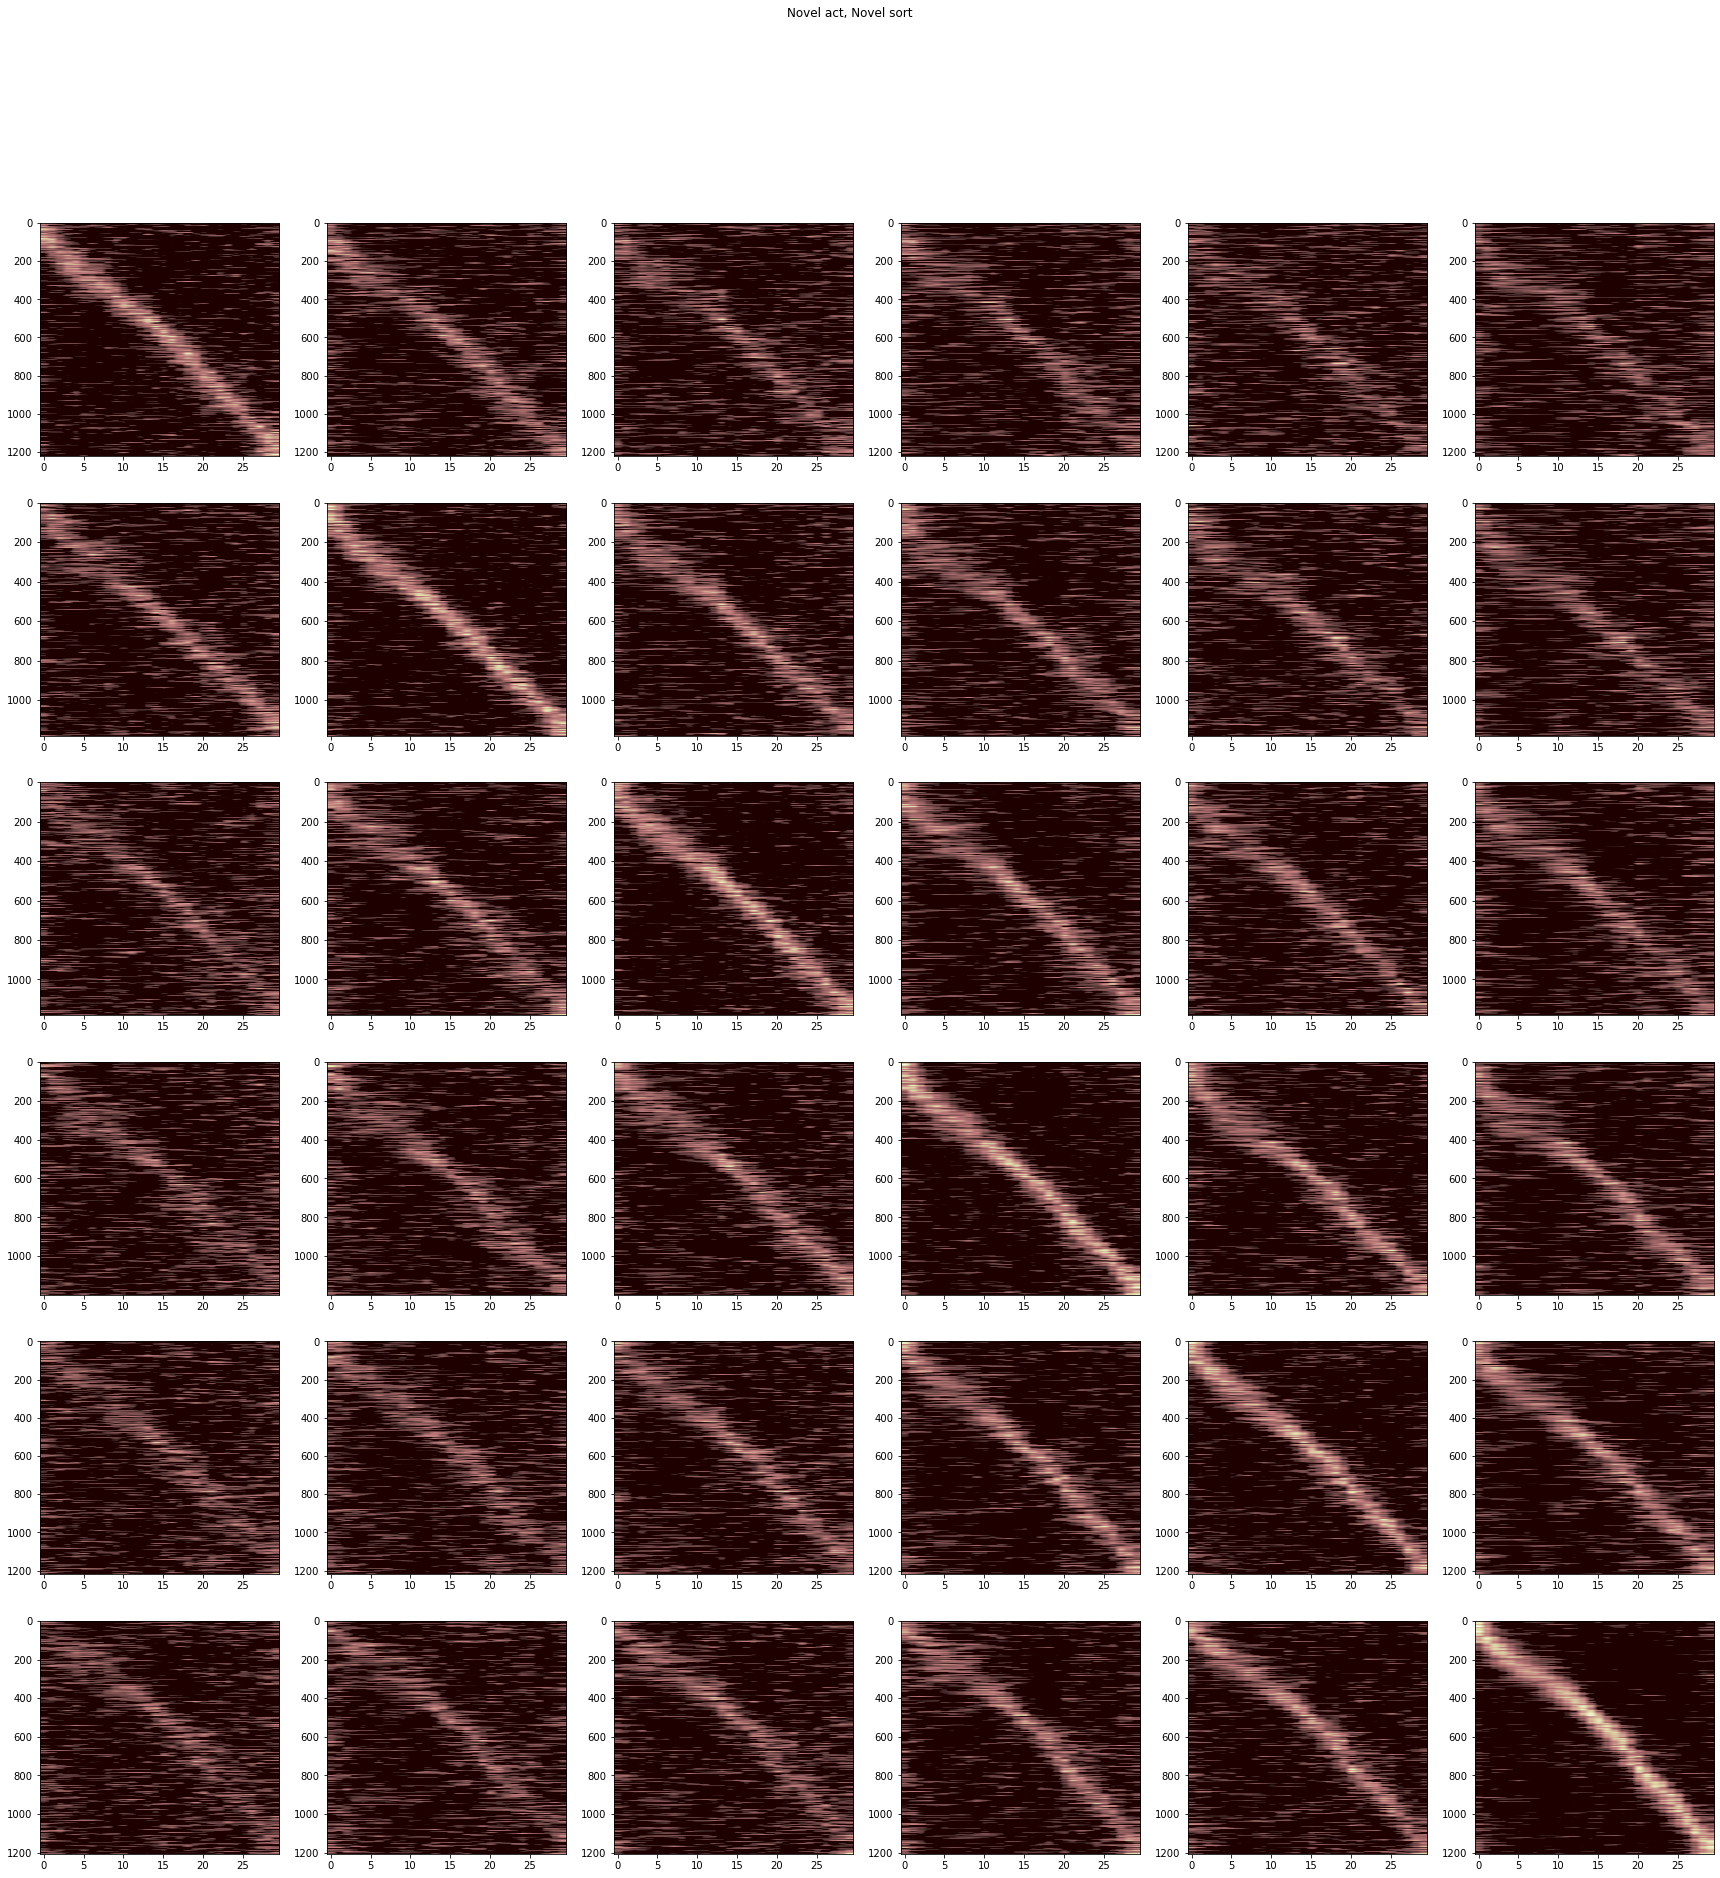

In [22]:
ff, fn, nf, nn = plot_crossval_placecells(ko_mice, max_sess=6, key = 'spks_norm')
ff[0].savefig(os.path.join(figdir,"KO_PlaceCells_FamAct_FamSort.pdf"), format = "pdf")
fn[0].savefig(os.path.join(figdir,"KO_PlaceCells_FamAct_NovSort.pdf"), format = "pdf")
nf[0].savefig(os.path.join(figdir,"KO_PlaceCells_NovAct_FamSort.pdf"), format = "pdf")
nn[0].savefig(os.path.join(figdir,"KO_PlaceCells_NovAct_NovSort.pdf"), format = "pdf")

In [ ]:
ff, fn, nf, nn = plot_crossval_placecells(ctrl_mice,max_sess=6, key = 'spks_norm')
ff[0].savefig(os.path.join(figdir,"CTRL_PlaceCells_FamAct_FamSort.pdf"), format = "pdf")
fn[0].savefig(os.path.join(figdir,"CTRL_PlaceCells_FamAct_NovSort.pdf"), format = "pdf")
nf[0].savefig(os.path.join(figdir,"CTRL_PlaceCells_NovAct_FamSort.pdf"), format = "pdf")
nn[0].savefig(os.path.join(figdir,"CTRL_PlaceCells_NovAct_NovSort.pdf"), format = "pdf")

In [12]:

def calc_simmat(trials_mat,popvec=False, metric = "corr"):
    
    if popvec:
        trials_t = np.transpose(trials_mat,axes = (1,0,2)) # positions x trials x cells
    else: 
        trials_t = np.transpose(trials_mat,axes = (2,0,1)) # cells x trials x positions
        
    assert metric in ("corr", "cos"), "invalid metric, metric must be 'corr' or 'cos' "
    if metric == "corr":
        trials_norm = sp.stats.zscore(trials_t, axis = 2)    
        return 1./trials_t.shape[2]*np.matmul(trials_norm, np.transpose(trials_norm, axes=(0,2,1)))
    if metric == "cos":
        trials_norm = trials_t/(np.linalg.norm(trials_t,axis=2,ord=2,keepdims=True) + 1E-3)
        return np.matmul(trials_norm,np.transpose(trials_norm, axes = (0,2,1)))
    

def single_sess_trial_sim(sess, trial_mask, key = "spks_norm", smooth_sigma = 1, nanless = True, cell_mask = None, **kwargs):
    
    trials_mat = sess.trial_matrices[key][trial_mask,:,:]
    if cell_mask is not None:
        trials_mat = trials_mat[:,:,cell_mask]
    
    if nanless:
        trials_mat[np.isnan(trials_mat)]=1E-5
    
    if smooth_sigma>0:
        trials_mat = sp.ndimage.filters.gaussian_filter1d(trials_mat, smooth_sigma, axis=1)
    
    return calc_simmat(trials_mat, **kwargs)
        
# def baseline_trial_sim(sess, **kwargs):
    
#     mask = np.zeros([sess.trial_info['block_number'].shape[0],])<1
#     mask[sess.trial_info['block_number']==5] = False
#     mask[sess.trial_info['LR']==sess.novel_arm]=False
    
#     return single_sess_trial_sim(sess, mask, **kwargs)

# def novel_trial_sim(sess, **kwargs):
    

def average_triu(sm):
    ''' sm : cells/positions x trials x trials'''
    iu = np.triu_indices(sm.shape[1],k=1)
    return sm[:,iu[0],iu[1]].mean(axis=-1)
    

def trial_sim_violinplots(ko_sim_dict, ctrl_sim_dict):
    fig,ax = plt.subplots(figsize= [15,5])
    
    n_days = len(ko_sim_dict[ko_mice[0]])
    ko_means = np.zeros([n_days,len(ko_mice)])
    for k, (mouse, data_list) in enumerate(ko_sim_dict.items()):
        for day, data in enumerate(data_list):
        
            ko_means[day,k]=data.mean()
            parts = ax.violinplot(data,positions=[2*day+.1*k],showextrema=False,showmeans=False,widths = .1, points= 10)
            _ = ax.scatter(2*day + .1*k, data.mean(),color='red')
            for pc in parts['bodies']:
                pc.set_facecolor('red')
                pc.set_edgecolor('black')
                pc.set_alpha(.5)

    ctrl_means = np.zeros([n_days,len(ctrl_mice)])
    for k, (mouse, data_list) in enumerate(ctrl_sim_dict.items()):
        for day, data in enumerate(data_list):
            ctrl_means[day,k] = data.mean()
            parts = ax.violinplot(data,positions=[2*day + .6+.1*k],showextrema=False,showmeans=False,widths = .1, points= 10)
            _ = ax.scatter(2*day + .6+ .1*k, data.mean(),color='black')
            for pc in parts['bodies']:
                pc.set_facecolor('black')
                pc.set_edgecolor('black')
                pc.set_alpha(.5)

        
    
        
    t,p = sp.stats.ttest_ind(ko_means,ctrl_means,axis=1)
    return (fig, ax), ko_means, ctrl_means, (t,p)

def print_ttest_res(t,p):
    for i, (_t,_p) in enumerate(zip(t.tolist(),p.tolist())):
        print("day %d: t=%f p=%f" % (i,_t,_p))
        

In [13]:
### trial x trial pop vec correlation

df = pd.DataFrame({'mouse': [],
                   'ko': [],
                   'nov': [],
                   'day': [],
                   'dz': [],
                   'ko_x_day': [],
                   'corr': [],
                   'intercept': []})

dz = sp.stats.zscore(np.arange(6))
for ko, mice in enumerate((ctrl_mice, ko_mice)):
    for m, mouse in enumerate(mice):
        for day, _dz in enumerate(dz):
            sess = u.load_single_day(mouse,day)
            for n, nov in enumerate([-1,1]):
                if nov == -1:
                    cell_mask = sess.fam_place_cell_mask()
                    trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
                else:
                    cell_mask = sess.nov_place_cell_mask()
                    trial_mask = sess.trial_info['LR']==sess.novel_arm

                trial_mat = sess.trial_matrices['spks_norm'][trial_mask,:,:][:,:, cell_mask]
                trial_mat[np.isnan(trial_mat)]= 1E-5
#                 print(average_triu(np.nanmean(calc_simmat(trial_mat, popvec = True),axis=0,keepdims=True))[0])
                df = df.append({'mouse': m + len(ctrl_mice)*ko,
                                'ko': ko,
                                'nov': n,
                                'day': day,
                                'dz': _dz,
                                'ko_x_day': ko*_dz,
                                'corr': average_triu(np.nanmean(calc_simmat(trial_mat, popvec = True),axis=0,keepdims=True))[0],
                                'intercept': 1,
                                }, ignore_index = True)


                            
                            
                
            
        

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 

In [14]:
lmm_res = MixedLM(df['corr'], df[['ko', 'dz', 'ko_x_day', 'nov', 'intercept']], df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: corr    
No. Observations: 120     Method:             REML    
No. Groups:       10      Scale:              0.0037  
Min. group size:  12      Log-Likelihood:     139.0653
Max. group size:  12      Converged:          Yes     
Mean group size:  12.0                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
ko           0.016    0.039  0.404 0.686 -0.061  0.093
dz           0.044    0.008  5.662 0.000  0.029  0.060
ko_x_day    -0.005    0.011 -0.418 0.676 -0.026  0.017
nov          0.091    0.011  8.236 0.000  0.070  0.113
intercept    0.273    0.028  9.631 0.000  0.217  0.328
Group Var    0.004    0.033                           



/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [15]:
print(df.columns)
aov = mixed_anova(data = df[df['nov']==1], dv= 'corr', between = 'ko', within = 'day', subject = 'mouse')
print(aov)

Index(['mouse', 'ko', 'nov', 'day', 'dz', 'ko_x_day', 'corr', 'intercept'], dtype='object')
        Source        SS  DF1  DF2        MS          F         p-unc  \
0           ko  0.010040    1    8  0.010040   0.374645  5.574746e-01   
1          day  0.230757    5   40  0.046151  35.656096  1.007632e-13   
2  Interaction  0.010214    5   40  0.002043   1.578243  1.883330e-01   

        np2       eps  
0  0.044736       NaN  
1  0.816750  0.642112  
2  0.164774       NaN  


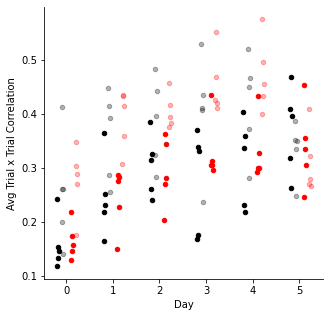

In [19]:
fig, ax = plt.subplots(figsize = [5,5])
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df['ko']==0) & (df['mouse'] == m) & (df['day']==day) & (df['nov']==0)
    
        corr = df['corr'].loc[mask ]
        ax.scatter(10*day+.1*m, np.nanmean(corr), color='black', s=20)
        
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df['ko']==0) & (df['mouse'] == m) & (df['day']==day) & (df['nov']==1)
    
        corr = df['corr'].loc[mask ]
        ax.scatter(10*day+.1*m + 1, np.nanmean(corr), color='black', s=20, alpha = .3)
        

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df['ko']==1) & (df['mouse'] == m+5) & (df['day']==day) & (df['nov']==0)
    
        corr = df['corr'].loc[mask ]
        ax.scatter(10*day+.1*m + 3, np.nanmean(corr), color='red', s=20)
        
for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df['ko']==1) & (df['mouse'] == m+5) & (df['day']==day) & (df['nov']==1)
    
        corr = df['corr'].loc[mask ]
        ax.scatter(10*day+.1*m + 4, np.nanmean(corr), color='red', s=20, alpha = .3)
        

ax.set_xticks(10*np.arange(6)+2)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')
ax.set_ylabel('Avg Trial x Trial Correlation')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir,"PopTrialXTrial_summary.pdf"), format = "pdf")

In [71]:
df = pd.DataFrame({'mouse': [],
                   'ko': [],
                   'day': [],
                   'dz': [],
                   'ko_x_day': [],
                   'corr': [],})

dz = sp.stats.zscore(np.arange(6))
for ko, mice in enumerate((ctrl_mice, ko_mice)):
    for m, mouse in enumerate(mice):
        for day, _dz in enumerate(dz):
            sess = u.load_single_day(mouse,day)
            cell_mask = sess.fam_place_cell_mask() + sess.nov_place_cell_mask() >0
                
            fam_mask = sess.trial_info["LR"]==-1*sess.novel_arm
            nov_mask = sess.trial_info["LR"]==sess.novel_arm
            
            trial_mat = sess.trial_matrices['spks_norm'][:,:,cell_mask]
            mat = np.zeros([2, *trial_mat.shape[1:]])
            mat[0,:,:] = np.nanmean(trial_mat[fam_mask,:,:], axis=0)
            mat[1,:,:] = np.nanmean(trial_mat[nov_mask,:,:], axis=0)
            
            df = df.append({'mouse': m + len(ctrl_mice)*ko,
                            'ko': ko,
                            'day': day,
                            'dz': _dz,
                            'ko_x_day': ko*_dz,
                            'corr': average_triu(np.nanmean(calc_simmat(mat, popvec = True),axis=0,keepdims=True))[0],
                            }, ignore_index = True)





{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', '

In [72]:
aov = mixed_anova(data = df, dv= 'corr', between = 'ko', within = 'day', subject = 'mouse')
print(aov)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0           ko  0.005770    1    8  0.005770  1.121725  0.320475  0.122973   
1          day  0.033184    5   40  0.006637  8.705874  0.000012  0.521127   
2  Interaction  0.003675    5   40  0.000735  0.964158  0.451207  0.107557   

        eps  
0       NaN  
1  0.625595  
2       NaN  


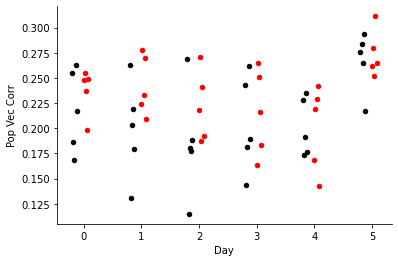

In [75]:
fig, ax = plt.subplots()
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df['ko']==0) & (df['mouse'] == m) & (df['day']==day) 
        corr = df['corr'].loc[mask ]
        ax.scatter(5*day+.1*m, np.nanmean(corr), color='black', s=20)
                

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df['ko']==1) & (df['mouse'] == m+5) & (df['day']==day)
        corr = df['corr'].loc[mask ]
        ax.scatter(5*day+.1*m + 1, np.nanmean(corr), color='red', s=20)
        

        

ax.set_xticks(5*np.arange(6)+1)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')
ax.set_ylabel('Pop Vec Corr')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir,"FamVNovel_summary.pdf"), format = "pdf")

In [76]:
def baseline_acrossday_placecells_sim(concat_sess,date_inds,key='F_dff', **kwargs):
    trials_mat = concat_sess.trial_matrices[key]
    day_mat = np.zeros([date_inds.shape[0], *trials_mat.shape[1:]])
    if concat_sess.novel_arm==-1:
        cellmask = concat_sess.place_cell_info[1]['masks'].sum(axis=0) >0
    else:
        cellmask = concat_sess.place_cell_info[-1]['masks'].sum(axis=0) > 0
        
    for j, day in enumerate(date_inds.tolist()):
        
        
        # day mask 
        mask = concat_sess.trial_info['sess_num']==day
#         mask[concat_sess.trial_info['block_number']==5] = False
        mask[concat_sess.trial_info['LR']==concat_sess.novel_arm]=False

        day_mat[j,:,:] = np.nanmean(trials_mat[mask,:,:],axis=0)
    return calc_simmat(day_mat[:,:,cellmask],**kwargs)

def run_baseline_acrossday_placecells_sim(mouse, date_inds = np.arange(0,6), **kwargs):
    concat_sess = u.single_mouse_concat_sessions(mouse,date_inds=date_inds)
    return baseline_acrossday_placecells_sim(concat_sess, date_inds, **kwargs) 


ko_baseline_corr = {mouse: run_baseline_acrossday_placecells_sim(mouse, key='spks_norm', popvec=True, metric = "corr") for mouse in ko_mice}
ctrl_baseline_corr = {mouse: run_baseline_acrossday_placecells_sim(mouse,  key='spks_norm', popvec=True, metric = "corr") for mouse in ctrl_mice}
    

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


28_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


29_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


30_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


01_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


02_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


28_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


29_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


30_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


01_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


02_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
29_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
01_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
03_12_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


05_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']


(5, 6, 6)
(5, 6, 6)
[[1.         0.88820094 0.97460848 0.94398423 0.94663392 0.69653233]
 [0.88820094 1.         0.32618711 0.69876665 0.52890378 0.9888902 ]
 [0.97460848 0.32618711 0.11749458 0.31443319 0.25880933 0.86115217]
 [0.94398423 0.69876665 0.31443319 1.         0.83583948 0.99199691]
 [0.94663392 0.52890378 0.25880933 0.83583948 1.         0.28976264]
 [0.69653233 0.9888902  0.86115217 0.99199691 0.28976264 1.        ]]


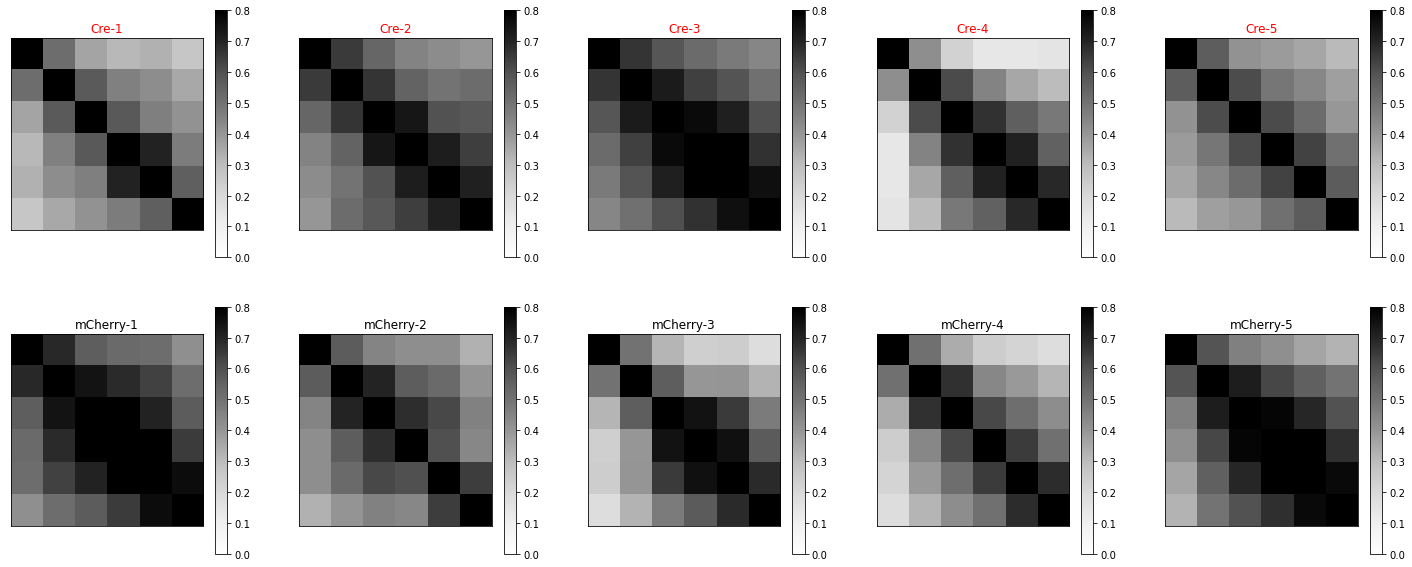

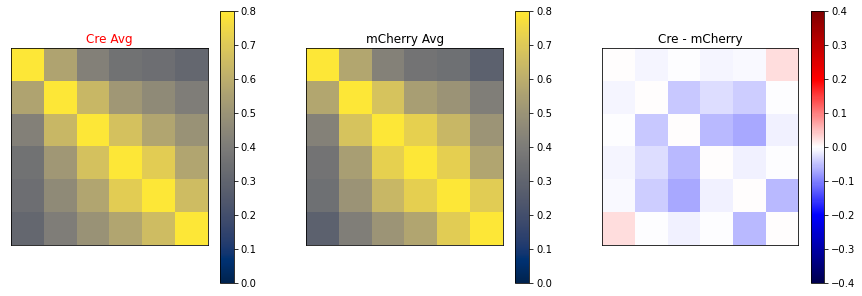

In [81]:
def plot_acrossday_corr(ko_corr, ctrl_corr, vmin = 0, vmax = .8):
    fig, ax = plt.subplots(2,5, figsize = [25,10])

    ko_all = np.zeros([5,*ko_corr[ko_mice[0]].shape[1:]])
#     ko_all = []
    for col, (mouse, arr) in enumerate(ko_corr.items()):
        h = ax[0,col].imshow(arr.mean(axis=0),cmap="Greys", vmax=vmax, vmin=vmin)
        fig.colorbar(h,ax=ax[0,col])
#         ko_all.append(arr)
        ko_all[col,:,:] = arr.mean(axis=0)
        ax[0,col].set_title("Cre-%d" % (col+1), color='red')
        ax[0,col].set_xticks([])
        ax[0,col].set_yticks([])
#     ko_all = np.concatenate(ko_all,axis=0)
    print(ko_all.shape)

    ctrl_all = np.zeros([5,*ko_corr[ko_mice[0]].shape[1:]])
#     ctrl_all = []
    for col, (mouse, arr) in enumerate(ctrl_corr.items()):
        h =ax[1,col].imshow(arr.mean(axis=0),cmap="Greys", vmax=vmax, vmin=vmin)
        fig.colorbar(h,ax=ax[1,col])
#         ctrl_all.append(arr)
        ctrl_all[col,:,:] = arr.mean(axis=0)
        ax[1,col].set_title("mCherry-%d" % (col+1), color='black')
        ax[1,col].set_xticks([])
        ax[1,col].set_yticks([])
#     ctrl_all = np.concatenate(ctrl_all,axis=0)
    print(ctrl_all.shape)

    fig, ax = plt.subplots(1,3, figsize=[15,5])
    h = ax[0].imshow(ko_all.mean(axis=0),vmin=vmin,vmax=vmax, cmap='cividis')
    fig.colorbar(h, ax = ax[0])
    ax[0].set_title("Cre Avg", color= "red")
    h = ax[1].imshow(ctrl_all.mean(axis=0),vmin=vmin,vmax=vmax, cmap='cividis')
    fig.colorbar(h, ax = ax[1])
    ax[1].set_title("mCherry Avg", color = "black")
    h = ax[2].imshow(ko_all.mean(axis=0)-ctrl_all.mean(axis=0),vmin=-.4,vmax=.4, cmap='seismic')
    ax[2].set_title("Cre - mCherry")
    fig.colorbar(h, ax = ax[2])
    for i in range(3):
        ax[i].set_xticks([])
        ax[i].set_yticks([])


    t,p = sp.stats.ttest_ind(ko_all,ctrl_all, axis=0)
    print(p)
    return fig, ax

fig, ax = plot_acrossday_corr(ko_baseline_corr, ctrl_baseline_corr)

fig.savefig(os.path.join(figdir,"baseline_day2day_corr.pdf"), format="pdf")

In [78]:
def novel_acrossday_sim(concat_sess,date_inds,key='F_dff', **kwargs):
    trials_mat = concat_sess.trial_matrices[key][:, :, nov_place_cell_mask(concat_sess)]
    day_mat = np.zeros([date_inds.shape[0], *trials_mat.shape[1:]])
    for j, day in enumerate(date_inds.tolist()):
        # day mask 
        mask = concat_sess.trial_info['sess_num']==day
        mask[concat_sess.trial_info['LR']==-1*concat_sess.novel_arm]=False

        day_mat[j,:,:] = np.nanmean(trials_mat[mask,:,:],axis=0)
    return calc_simmat(day_mat,**kwargs)

def run_novel_acrossday_sim(mouse, date_inds = np.arange(0,6), **kwargs):
    concat_sess = u.single_mouse_concat_sessions(mouse,date_inds=date_inds)
    return novel_acrossday_sim(concat_sess, date_inds, **kwargs) 

ko_novel_corr = {mouse: run_novel_acrossday_sim(mouse, key='spks_norm', popvec=True, metric = "corr") for mouse in ko_mice}
ctrl_novel_corr = {mouse: run_novel_acrossday_sim(mouse,  key='spks_norm', popvec=True, metric = "corr") for mouse in ctrl_mice}
    

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


28_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


29_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


30_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


01_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


02_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


28_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


29_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


30_09_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


01_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


02_10_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
03_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
29_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
01_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
03_12_2020 YMaze_LNovel


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


05_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']


(5, 6, 6)
(5, 6, 6)
[[1.         0.96147431 0.32912766 0.89321127 0.6925514  0.17758899]
 [0.96147431 1.         0.39822887 0.96153674 0.78091712 0.41792653]
 [0.32912766 0.39822887 1.         0.26286289 0.09575491 0.34992566]
 [0.89321127 0.96153674 0.26286289 1.         0.25652518 0.59249788]
 [0.6925514  0.78091712 0.09575491 0.25652518 1.         0.36019997]
 [0.17758899 0.41792653 0.34992566 0.59249788 0.36019997 1.        ]]


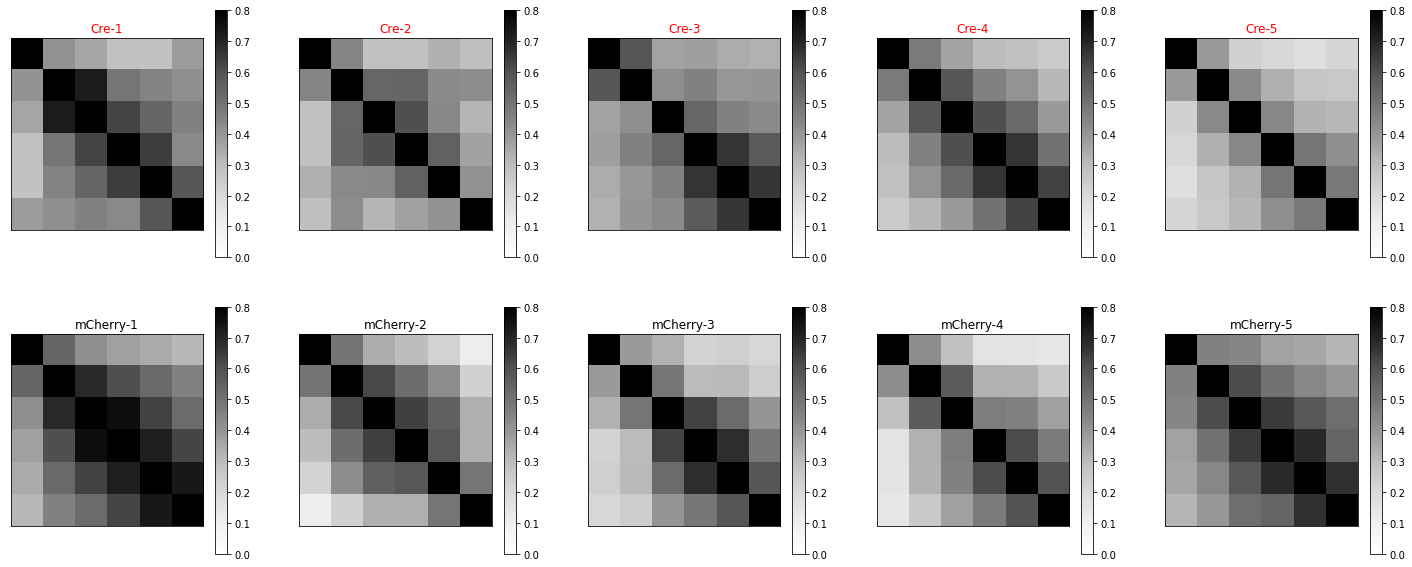

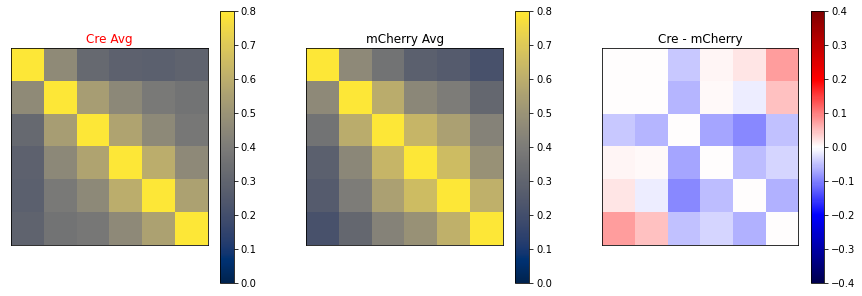

In [82]:
fig, ax = plot_acrossday_corr(ko_novel_corr, ctrl_novel_corr,vmax=.8,vmin=0)
fig.savefig(os.path.join(figdir,"novel_day2day_corr.pdf"), format="pdf")

NameError: name 'figdir' is not defined

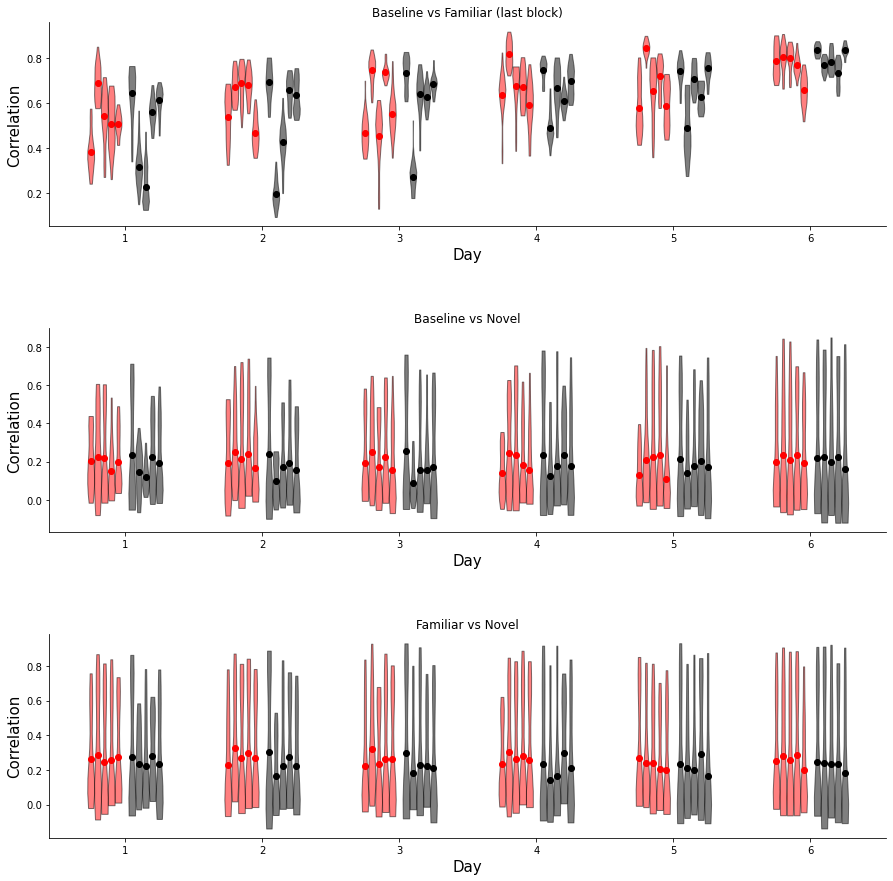

In [13]:
def parts_editor(parts, color):
    for pc in parts['bodies']:
                pc.set_facecolor(color)
                pc.set_edgecolor('black')
                pc.set_alpha(.5)

def trialtype_sim_violinplots(ko_sim_dict, ctrl_sim_dict):
    fig,ax = plt.subplots(3,1, figsize= [15,15])
    fig.subplots_adjust(hspace=.5)
    
    n_days = len(ko_sim_dict[ko_mice[0]])
    ko_means = np.zeros([n_days,len(ko_mice), 3])
    for k, (mouse, data_list) in enumerate(ko_sim_dict.items()):
        for day, data in enumerate(data_list):
        
            ko_means[day,k, 0]=data[:,0,1].mean()
            parts = ax[0].violinplot(data[:,0,1],positions=[2*day+.1*k],showextrema=False,showmeans=False,widths = .1, points= 10)
            _ = ax[0].scatter(2*day + .1*k, data[:,0,1].mean(),color='red')
            parts_editor(parts,'red')
            
            ko_means[day,k, 1]=data[:,0,2].mean()
            parts = ax[1].violinplot(data[:,0,2],positions=[2*day+.1*k],showextrema=False,showmeans=False,widths = .1, points= 10)
            _ = ax[1].scatter(2*day + .1*k, data[:,0,2].mean(),color='red')
            parts_editor(parts,'red')
            
            ko_means[day,k, 2]=data[:,1,2].mean()
            parts = ax[2].violinplot(data[:,1,2],positions=[2*day+.1*k],showextrema=False,showmeans=False,widths = .1, points= 10)
            _ = ax[2].scatter(2*day + .1*k, data[:,1,2].mean(),color='red')
            parts_editor(parts,'red')
            
            

    ctrl_means = np.zeros([n_days,len(ctrl_mice), 3])
    for k, (mouse, data_list) in enumerate(ctrl_sim_dict.items()):
        for day, data in enumerate(data_list):
            ctrl_means[day,k,0] = data[:,0,1].mean()
            parts = ax[0].violinplot(data[:,0,1],positions=[2*day + .6+.1*k],showextrema=False,showmeans=False,widths = .1, points= 10)
            _ = ax[0].scatter(2*day + .6+ .1*k, data[:,0,1].mean(),color='black')
            parts_editor(parts,'black')
            
            ctrl_means[day,k, 1]=data[:,0,2].mean()
            parts = ax[1].violinplot(data[:,0,2],positions=[2*day+ .6 + .1*k],showextrema=False,showmeans=False,widths = .1, points= 10)
            _ = ax[1].scatter(2*day + .6 +  .1*k, data[:,0,2].mean(),color='black')
            parts_editor(parts, 'black')
            
            ctrl_means[day,k, 2]=data[:,1,2].mean()
            parts = ax[2].violinplot(data[:,1,2],positions=[2*day+ .6 + .1*k],showextrema=False,showmeans=False,widths = .1, points= 10)
            _ = ax[2].scatter(2*day + .6 +  .1*k, data[:,1,2].mean(),color='black')
            parts_editor(parts, 'black')
    
    t,p = sp.stats.ttest_ind(ko_means,ctrl_means,axis=1)
    
    ax[0].set_title('Baseline vs Familiar (last block)')
    ax[1].set_title('Baseline vs Novel')
    ax[2].set_title('Familiar vs Novel')
    for a in range(3):
        ax[a].spines['top'].set_visible(False)
        ax[a].spines['right'].set_visible(False)
        ax[a].set_ylabel('Correlation', fontsize=15)
        ax[a].set_xticks([i+.5 for i in range(0,12,2)])
        ax[a].set_xticklabels([1, 2, 3, 4, 5, 6])
        ax[a].set_xlabel('Day', fontsize=15)
        
    return (fig, ax), ko_means, ctrl_means, (t,p)

def print_ttest_res(t,p):
    for i, (_t,_p) in enumerate(zip(t.tolist(),p.tolist())):
        print("day %d:" %  i)
        print(_t,_p)


(fig, ax), ko_means, ctrl_means, (t,p) = trialtype_sim_violinplots(ko_fam_v_novel_corr, ctrl_fam_v_novel_corr)
fig.savefig(os.path.join(figdir, "trialtype_corr.pdf"),format="pdf")
print_ttest_res(t,p)

In [28]:
# fraction of place cells 

In [84]:
def get_common_pc_frac(concat_sess):
    unique_days = np.unique(concat_sess.day_inds)
    
    l_frac, r_frac = [], []
    for day in unique_days:
        day_mask = concat_sess.day_inds==day
        if day_mask.sum()>1:
            l_frac.append((concat_sess.place_cell_info[-1]['masks'][day_mask,:].sum(axis=0)>0).mean())
            r_frac.append((concat_sess.place_cell_info[1]['masks'][day_mask,:].sum(axis=0)>0).mean())
        else:
            l_frac.append(concat_sess.place_cell_info[-1]['masks'][day_mask,:].mean())
            r_frac.append(concat_sess.place_cell_info[1]['masks'][day_mask,:].mean())
            
    if concat_sess.novel_arm == -1:
        return np.array(r_frac), np.array(l_frac)
    else:
        return np.array(l_frac), np.array(r_frac)
            
ko_pc_frac = {mouse:get_common_pc_frac(u.single_mouse_concat_sessions(mouse, date_inds=np.arange(5))) for mouse in ko_mice}  
ctrl_pc_frac = {mouse:get_common_pc_frac(u.single_mouse_concat_sessions(mouse, date_inds=np.arange(5))) for mouse in ctrl_mice}  
    
                
            


28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel
02_10_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
28_09_2020 YMaze_LNovel
29_09_2020 YMaze_LNovel
30_09_2020 YMaze_LNovel
01_10_2020 YMaze_LNovel


In [88]:
df = pd.DataFrame({'ko_ctrl':[],
     'day':[],
     'frac':[],
      'nov': [],
     'mouse':[]})

for mouse,data_list in ko_pc_frac.items():
    for nov, _data_list in enumerate(data_list):
        for day, data in enumerate(_data_list):
            df = df.append({ 'mouse': mouse,
                            'nov': nov,
                            'ko_ctrl': 1,
                            'day': day,
                            'frac': data}, ignore_index=True)
                
for mouse,data_list in ctrl_pc_frac.items():
    for nov, _data_list in enumerate(data_list):
        for day, data in enumerate(_data_list):
            df = df.append({ 'mouse': mouse,
                            'nov': nov,
                            'ko_ctrl': 0,
                            'day': day,
                            'frac': data}, ignore_index=True)
                

aov = mixed_anova(data=df[df['nov']==0],dv='frac',between='ko_ctrl', within='day', subject='mouse')
print(aov)


print('Tukey test on pairwise day')
stats = pairwise_tukey(data= df, dv='frac', between = 'ko_ctrl')
print(stats)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0      ko_ctrl  0.001922    1    8  0.001922  0.159872  0.699738  0.019592   
1          day  0.027924    4   32  0.006981  1.921091  0.130943  0.193637   
2  Interaction  0.007050    4   32  0.001763  0.485039  0.746555  0.057164   

        eps  
0       NaN  
1  0.766238  
2       NaN  
Tukey test on pairwise day
     A    B   mean(A)   mean(B)      diff        se         T   p-tukey  \
0  0.0  1.0  0.701957  0.680534  0.021423  0.032586  0.657435  0.514206   

     hedges  
0  0.130478  


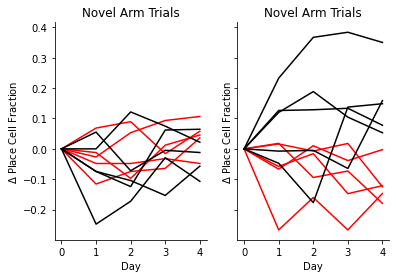

In [92]:
fig,ax = plt.subplots(1,2, sharey=True)

for mouse, data in ko_pc_frac.items():
    data = np.array(data[0])
    ax[0].plot(data-data[0],color='red')
    
    
for mouse, data in ctrl_pc_frac.items():
    data = np.array(data[0])
    ax[0].plot(data-data[0],color='black') 


for mouse, data in ko_pc_frac.items():
    data = np.array(data[1])
    ax[1].plot(data-data[0],color='red')
    
    
for mouse, data in ctrl_pc_frac.items():
    data = np.array(data[1])
    ax[1].plot(data-data[0],color='black')

    

    
for a in range(2):
    ax[a].set_ylabel(r"$\Delta$ Place Cell Fraction")
    ax[a].set_xlabel("Day")
    ax[a].set_title("Novel Arm Trials")
    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir,"novel_placecellfrac_interaction.pdf"))

In [68]:
def get_fam_si(sess):
    cellmask = fam_place_cell_mask(sess)
    if sess.novel_arm==-1:
        try:
            return sess.place_cell_info['right']['SI'][cellmask]
        except:
            return sess.place_cell_info[1]['SI'][-1,cellmask]
    else:
        try:
            return sess.place_cell_info['left']['SI'][cellmask]
        except:
            return sess.place_cell_info[-1]['SI'][-1,cellmask]

si_fam_alldays = lambda mouse, days: [get_fam_si(u.load_single_day(mouse,day = day)) for day in days]
ko_si_fam = {mouse: si_fam_alldays(mouse,range(6)) for mouse in ko_mice}
ctrl_si_fam = {mouse: si_fam_alldays(mouse,range(6)) for mouse in ctrl_mice}

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 6}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel': 1, '

day 0:
1.3578057164544433 0.17452534056858338
day 1:
0.5222329678670935 0.6015081344405899
day 2:
2.1933784650417927 0.028280122568276955
day 3:
0.731126155013931 0.46470209994046485
day 4:
1.1489125293076057 0.25059205068568424
day 5:
0.5222329678670935 0.6015081344405899


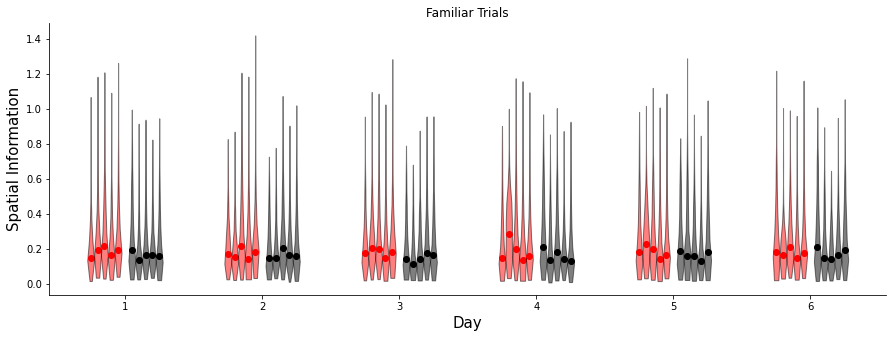

In [78]:
def si_violinplots(ko_sim_dict, ctrl_sim_dict):
    fig,ax = plt.subplots(figsize= [15,5])
    
    n_days = len(ko_sim_dict[ko_mice[0]])
    ko_means = np.zeros([n_days,len(ko_mice)])
    for k, (mouse, data_list) in enumerate(ko_sim_dict.items()):
        for day, data in enumerate(data_list):
        
            ko_means[day,k]=np.median(data)
            parts = ax.violinplot(data,positions=[2*day+.1*k],showextrema=False,showmeans=False,widths = .1, points= 10)
            _ = ax.scatter(2*day + .1*k, np.median(data),color='red')
            for pc in parts['bodies']:
                pc.set_facecolor('red')
                pc.set_edgecolor('black')
                pc.set_alpha(.5)

    ctrl_means = np.zeros([n_days,len(ctrl_mice)])
    for k, (mouse, data_list) in enumerate(ctrl_sim_dict.items()):
        for day, data in enumerate(data_list):
            ctrl_means[day,k] = np.median(data)
            parts = ax.violinplot(data,positions=[2*day + .6+.1*k],showextrema=False,showmeans=False,widths = .1, points= 10)
            _ = ax.scatter(2*day + .6+ .1*k, np.median(data),color='black')
            for pc in parts['bodies']:
                pc.set_facecolor('black')
                pc.set_edgecolor('black')
                pc.set_alpha(.5)

        
    
    res = np.array([sp.stats.ranksums(ko_means[d,:],ctrl_means[d,:]) for d in range(n_days)])
    t,p = res[:,0], res[:,1]
    return (fig, ax), ko_means, ctrl_means, (t,p)

(fig, ax), ko_means, ctrl_means, (t,p) = si_violinplots(ko_si_fam, ctrl_si_fam)
print_ttest_res(t,p)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Spatial Information', fontsize=15)
ax.set_xticks([i+.5 for i in range(0,12,2)])
ax.set_xticklabels([1, 2, 3, 4, 5, 6])
ax.set_xlabel('Day', fontsize=15)
_ =ax.set_title('Familiar Trials')
fig.savefig(os.path.join(figdir,"familiar_spatialinfo.pdf"),format = "pdf")

In [46]:
df = {'ko_ctrl':[],
     'day':[],
     'si':[],
     'mouse':[]}

for mouse,data_list in ko_si_fam.items():
    for day, data in enumerate(data_list):
        
        df['ko_ctrl'].append(0)
        df['day'].append(day)
        df['si'].append(data.mean())
        df['mouse'].append(mouse)
        
for mouse,data_list in ctrl_si_fam.items():
    for day, data in enumerate(data_list):
        
        df['ko_ctrl'].append(1)
        df['day'].append(day)
        df['si'].append(data.mean())
        df['mouse'].append(mouse)

        
df = pd.DataFrame(df)
aov = anova(data=df,dv='si',between=['ko_ctrl', 'day'])
print(aov)


print('Tukey test on groups')
stats = pairwise_tukey(data= df, dv='si', between = 'ko_ctrl')
print(stats)


NameError: name 'ko_si_fam' is not defined

In [80]:
def get_nov_si(sess):
    cellmask=nov_place_cell_mask(sess)
    if sess.novel_arm==1:
        try:
            return sess.place_cell_info['right']['SI'][cellmask]
        except:
            return sess.place_cell_info[1]['SI'][-1,cellmask]
    else:
        try:
            return sess.place_cell_info['left']['SI'][cellmask]
        except:
            return sess.place_cell_info[-1]['SI'][-1,cellmask]

si_nov_alldays = lambda mouse, days: [get_nov_si(u.load_single_day(mouse,day = day)) for day in days]
ko_si_nov = {mouse: si_nov_alldays(mouse,range(6)) for mouse in ko_mice}
ctrl_si_nov = {mouse: si_nov_alldays(mouse,range(6)) for mouse in ctrl_mice}

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': -1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': -1, 'ravel_ind': 6}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel': 1, '

day 0:
0.9400193421607683 0.34720763934942456
day 1:
-0.3133397807202561 0.7540225300620748
day 2:
-0.3133397807202561 0.7540225300620748
day 3:
-0.1044465935734187 0.9168149485280885
day 4:
0.1044465935734187 0.9168149485280885
day 5:
1.5666989036012806 0.11718508719813801


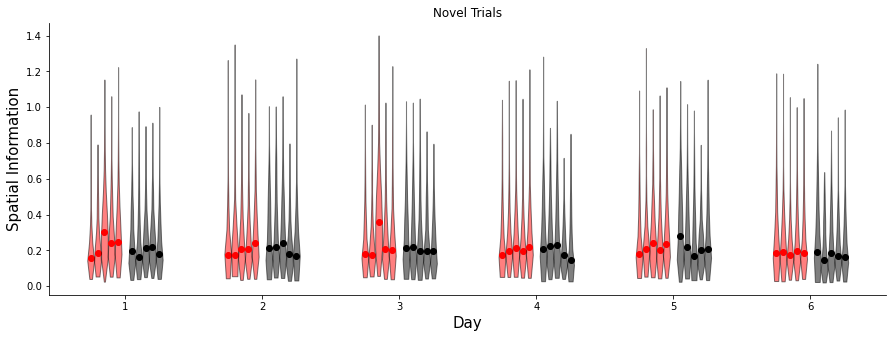

In [81]:
(fig, ax), ko_means, ctrl_means, (t,p) = si_violinplots(ko_si_nov, ctrl_si_nov)
print_ttest_res(t,p)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Spatial Information', fontsize=15)
ax.set_xticks([i+.5 for i in range(0,12,2)])
ax.set_xticklabels([1, 2, 3, 4, 5, 6])
ax.set_xlabel('Day', fontsize=15)
_ =ax.set_title('Novel Trials')
fig.savefig(os.path.join(figdir,"spatialinformation_noveltrials.pdf"),format = "pdf")

In [82]:
df = {'ko_ctrl':[],
     'day':[],
     'si':[],
     'mouse':[]}

for mouse,data_list in ko_si_nov.items():
    for day, data in enumerate(data_list):
        
        df['ko_ctrl'].append(0)
        df['day'].append(day)
        df['si'].append(data.mean())
        df['mouse'].append(mouse)
        
for mouse,data_list in ctrl_si_nov.items():
    for day, data in enumerate(data_list):
        
        df['ko_ctrl'].append(1)
        df['day'].append(day)
        df['si'].append(data.mean())
        df['mouse'].append(mouse)

        
df = pd.DataFrame(df)
aov = anova(data=df,dv='si',between=['ko_ctrl', 'day'])
print(aov)


print('Tukey test on groups')
stats = pairwise_tukey(data= df, dv='si', between = 'ko_ctrl')
print(stats)

          Source        SS  DF        MS         F     p-unc       np2
0        ko_ctrl  0.000536   1  0.000536  0.461923  0.499991  0.009532
1            day  0.008989   5  0.001798  1.549476  0.192470  0.138973
2  ko_ctrl * day  0.002054   5  0.000411  0.354106  0.877088  0.035574
3       Residual  0.055695  48  0.001160       NaN       NaN       NaN
Tukey test on groups
   A  B   mean(A)   mean(B)      diff        se         T   p-tukey   hedges
0  0  1  0.255534  0.249556  0.005978  0.008758  0.682491  0.497645  0.17393
